In [58]:
# https://goo.gl/PAswVJ
# https://goo.gl/ePhgbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydicom
import numpy as np
import warnings
import multiprocessing
import os

warnings.filterwarnings('ignore')

In [91]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=.8)

In [4]:
RAWDATA_DIR = os.path.join('..', 'data', 'raw')

In [67]:
df = pd.read_csv(os.path.join(RAWDATA_DIR, 'stage_1_train_labels.csv'))
df['aspect_ratio'] = df['width'] / df['height']
df['area'] = df['width'] * df['height']
df['center_x'] = df['x'] + 0.5*df['width']
df['center_y'] = df['y'] + 0.5*df['height']
patient_ids = list(df.patientId.unique())

In [209]:
df_patient_class = pd.read_csv(os.path.join(RAWDATA_DIR, 'stage_1_detailed_class_info.csv'), index_col=0)

In [6]:
def get_info(patientId, root_dir=os.path.join(RAWDATA_DIR, 'stage_1_train_images/')):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return {'age': dcm_data.PatientAge, 
            'gender': dcm_data.PatientSex, 
            'id': os.path.basename(fn).split('.')[0],
            'pixel_spacing': float(dcm_data.PixelSpacing[0]),
            'mean_black_pixels': np.mean(dcm_data.pixel_array == 0)}

In [68]:
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, patient_ids)
demo = pd.DataFrame(result)
demo['gender'] = demo['gender'].astype('category')
demo['age'] = demo['age'].astype(int)

df = df.merge(demo, left_on='patientId', right_on='id', how='left').drop(columns='id')

In [72]:
df.describe()

,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,age,mean_black_pixels,pixel_spacing
count,8964.000000,8964.000000,8964.000000,8964.000000,28989.000000,8964.000000,8964.000000,8964.000000,8964.000000,28989.000000,28989.000000,28989.000000
mean,391.456158,363.135877,220.845382,334.174364,0.309221,0.780815,79332.644021,501.878849,530.223059,46.790645,0.025676,0.155482
std,203.945378,148.607149,59.041384,158.097239,0.462180,0.349680,52121.602120,204.625301,114.515473,16.916193,0.051979,0.015828
min,2.000000,2.000000,40.000000,45.000000,0.000000,0.219144,2320.000000,93.000000,130.000000,1.000000,0.000000,0.115000
25%,205.000000,246.000000,180.000000,207.000000,0.000000,0.527110,38734.500000,314.500000,454.500000,34.000000,0.001116,0.143000
50%,320.000000,360.000000,219.000000,304.000000,0.000000,0.688073,67157.000000,412.250000,529.500000,49.000000,0.004792,0.143000
75%,591.000000,475.000000,261.000000,445.000000,1.000000,0.951818,108776.250000,708.000000,607.500000,59.000000,0.031133,0.168000
max,817.000000,881.000000,528.000000,942.000000,1.000000,4.361702,371184.000000,899.500000,945.000000,155.000000,0.710204,0.198800


In [189]:
df['patientId'][:10]

0    0004cfab-14fd-4e49-80ba-63a80b6bddd6
1    00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2    00322d4d-1c29-4943-afc9-b6754be640eb
3    003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4    00436515-870c-4b36-a041-de91049b9ab4
5    00436515-870c-4b36-a041-de91049b9ab4
6    00569f44-917d-4c86-a842-81832af98c30
7    006cec2e-6ce2-4549-bffa-eadfcd1e9970
8    00704310-78a8-4b38-8475-49f4573b2dbb
9    00704310-78a8-4b38-8475-49f4573b2dbb
Name: patientId, dtype: object

In [190]:
df[df['patientId'] == '0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,age,gender,mean_black_pixels,pixel_spacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,51,F,0.029041,0.143


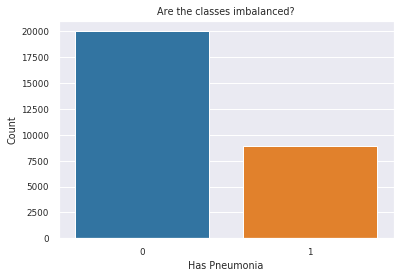

In [70]:
ax = sns.countplot(df['Target'])
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')

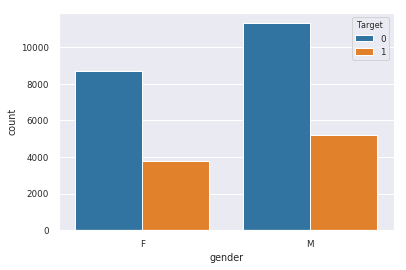

In [74]:
ax = sns.countplot(df['gender'], hue=df['Target'])

In [59]:
boxes_per_patient = df.groupby(['patientId'])['Target'].sum()

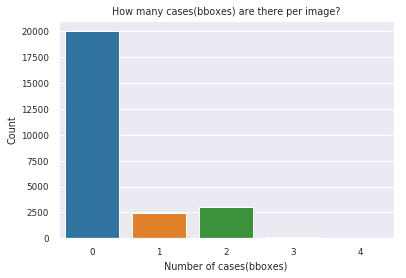

In [60]:
ax = sns.countplot(boxes_per_patient)
_ = ax.set_title('How many cases(bboxes) are there per image?')
_ = ax.set_xlabel('Number of cases(bboxes)')
_ = ax.set_ylabel('Count')

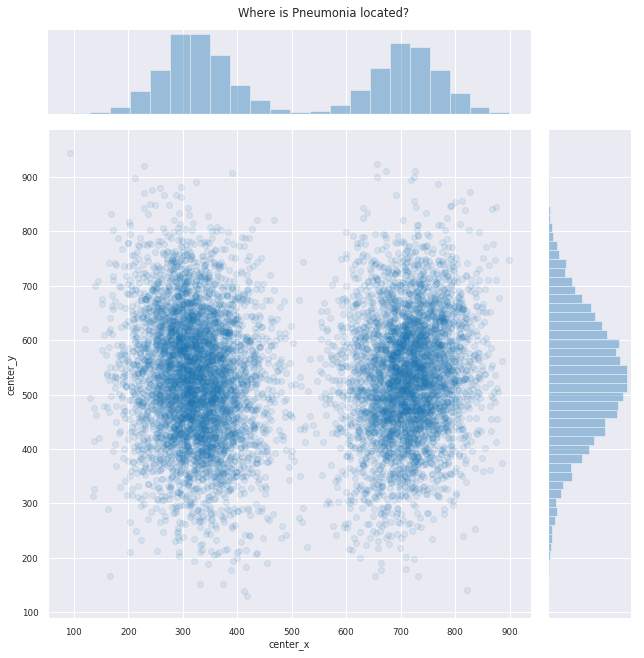

In [46]:
ax = sns.jointplot("center_x", "center_y", data=df, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

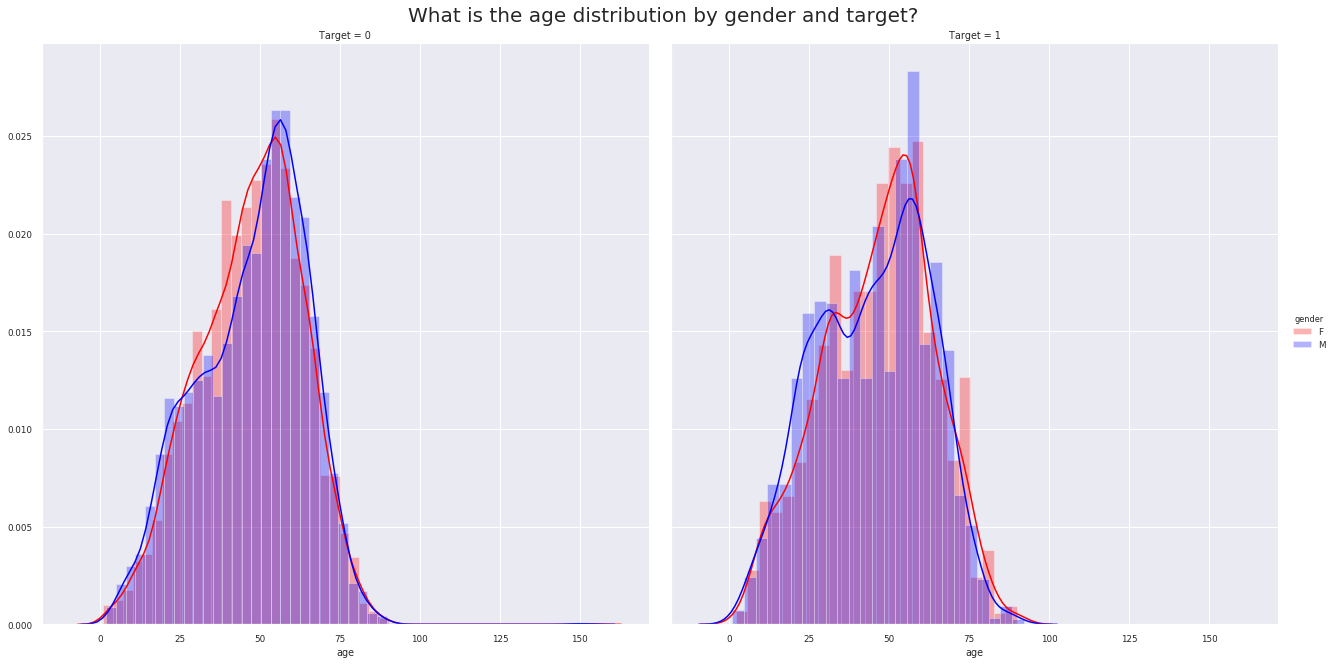

In [92]:
g = sns.FacetGrid(col='Target', hue='gender', 
                  data=tr.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'age', hist_kws={'alpha': 0.3}).add_legend()
_ = g.fig.suptitle("What is the age distribution by gender and target?", y=1.02, fontsize=20)

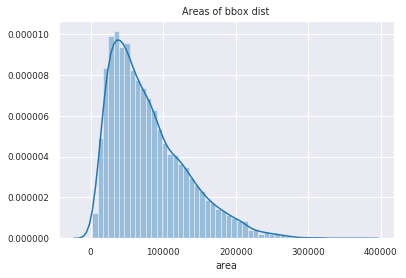

In [97]:
ax = sns.distplot(df.dropna(subset=['area'])['area'])
_ = ax.set_title('Areas of bbox dist')

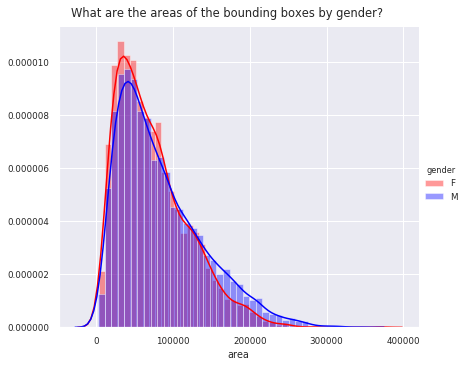

In [96]:
g = sns.FacetGrid(
    data=df.dropna(subset=['area']),
    hue="gender",
    height=5, palette=dict(F="red", M="blue"), aspect=1.2)
_ = g.map(sns.distplot, "area").add_legend()
_ = g.fig.suptitle('What are the areas of the bounding boxes by gender?', y=1.01)

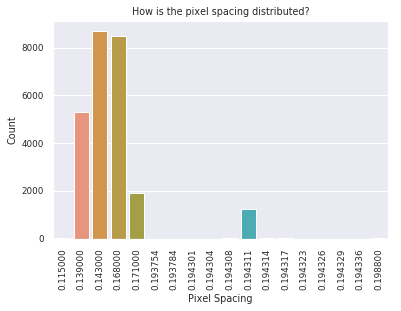

In [166]:
ax = sns.countplot(df.drop_duplicates('patientId')['pixel_spacing'])
_ = ax.set_xticklabels(["{0:.6f}".format(round(float(i._text), 6)) for i in ax.get_xticklabels()])
_ = ax.set_xlabel('Pixel Spacing')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set_ylabel('Count')
_ = ax.set_title('How is the pixel spacing distributed?')

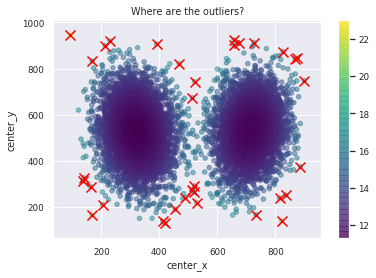

In [187]:
from sklearn.mixture import GaussianMixture
threshold = 17
clf = GaussianMixture(n_components=2)
df_centers = df.dropna(subset=['x'])[['center_x', 'center_y']]
clf.fit(df_centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(df_centers[['center_x', 'center_y']])
Z = -clf.score_samples(df_centers[['center_x', 'center_y']])
df_outliers = df_centers.iloc[Z > threshold]
fig, ax = plt.subplots()
df_centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
df_outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?')

In [200]:
import matplotlib.patches as patches

def get_image(patient_id, root_dir=os.path.join(RAWDATA_DIR, 'stage_1_train_images')):
    filename = os.path.join(root_dir, f'{patient_id}.dcm')
    dcm_data = pydicom.read_file(filename)
    return dcm_data.pixel_array

def draw_bboxes(bboxes, ax):
    for bbox in bboxes.itertuples():
        rect = patches.Rectangle(
            (bbox.x, bbox.y), bbox.width, bbox.height,
            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
def draw_image(df, patient_id, ax):
    img = get_image(patient_id)
    
    bboxes = df.loc[df.patientId == patient_id, ['x', 'y', 'width', 'height']]
    draw_bboxes(bboxes, ax)

    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.axis('off')

In [207]:
df[df.Target == 1]

,patientId,x,y,width,height,Target,aspect_ratio,area,center_x,center_y,age,gender,mean_black_pixels,pixel_spacing
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,370.5,341.5,32,F,2.634048e-03,0.139
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,0.565121,115968.0,690.0,378.5,32,F,2.634048e-03,0.139
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,1.538462,16640.0,403.0,629.0,75,M,5.422401e-02,0.143
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,1.182482,22194.0,776.0,643.5,75,M,5.422401e-02,0.143
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,0.696296,12690.0,335.0,389.5,6,F,5.066223e-01,0.168
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1,0.721212,19635.0,606.5,381.5,6,F,5.066223e-01,0.168
16,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,0.688525,40992.0,390.0,666.0,23,F,1.965284e-01,0.171
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1,0.725352,58504.0,753.0,653.0,23,F,1.965284e-01,0.171
19,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,0.407115,104236.0,284.0,437.0,58,M,2.475739e-03,0.139
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1,0.483193,109480.0,686.0,513.0,58,M,2.475739e-03,0.139


class    Lung Opacity
Name: 0100515c-5204-4f31-98e0-f35e4b00004a, dtype: object


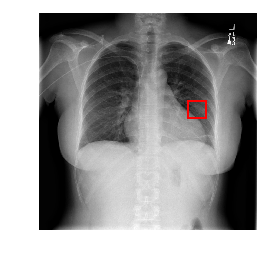

In [210]:
patient_id = '0100515c-5204-4f31-98e0-f35e4b00004a'
_, ax = plt.subplots()
print(df_patient_class.loc[patient_id])
draw_image(df, patient_id, ax)